In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Settings

1) important required libraries

In [43]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import time
import matplotlib.pyplot as plt

In [44]:
from google.colab import files
files.upload()

Saving utils.py to utils (1).py


{'utils.py': b'# -*- coding: utf-8 -*-\nimport numpy as np\nimport torch\nimport torch.utils.data as data\nfrom torch.autograd import Variable\n\ndef func(num):\n    print(num)\n# ================================================================\n# Compute correct ratio (Recall)\n# ================================================================\n# * \xec\xa3\xbc\xec\x9d\x98! dropout or batch normalization \xec\x9d\x84 \xec\xa0\x81\xec\x9a\xa9\xed\x95\x9c \xeb\xaa\xa8\xeb\x8d\xb8\xec\x9d\xb4\xeb\x9d\xbc\xeb\xa9\xb4, \n#  \xeb\xb0\x98\xeb\x93\x9c\xec\x8b\x9c model.eval() <--> model.train() \n#  evaluation mode \xeb\xa1\x9c \xeb\xb3\x80\xea\xb2\xbd\xed\x95\x9c \xed\x9b\x84 \xed\x95\xa8\xec\x88\x98 \xed\x98\xb8\xec\xb6\x9c\xed\x95\xa0 \xea\xb2\x83\n# * \xed\x98\xb8\xec\xb6\x9c \xeb\xb0\xa9\xeb\xb2\x95\n#  print(utils.ComputeCorr(test_batch, model))\ndef ComputeCorr(i_data_batch, i_model):  \n    correct = 0\n    total = 0\n    for img, label in i_data_batch:\n        torch.no_grad()\n     

In [45]:
import utils

## 2) Hyperparameter

In [46]:
batch_size=16
learning_rate=0.0001
epoch=20

n_node=1024 #customized last layer의 node 수
dropratio=0.5

imgsize=256

## 2.Data Loader
트레이닝 데이터

고정된 데이터 셋

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
img_dir="/content/drive/MyDrive/Colab Notebooks/dataset/fruit/train"
train_data=dset.ImageFolder(img_dir,transforms.Compose([
    transforms.CenterCrop(imgsize*2),
    transforms.RandomCrop(imgsize),
    transforms.RandomHorizontalFlip(),
    
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))
print(train_data.__len__())
train_batch=data.DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=2)

21


Dev(val) data

In [66]:
img_dir="/content/drive/MyDrive/Colab Notebooks/dataset/fruit/val"
dev_data=dset.ImageFolder(img_dir,transforms.Compose([
    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))
dev_batch=data.DataLoader(dev_data,batch_size=batch_size,shuffle=True,num_workers=2)

Test data

In [67]:
img_dir="/content/drive/MyDrive/Colab Notebooks/dataset/fruit/test"
test_data=dset.ImageFolder(img_dir,transforms.Compose([
    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))
test_batch=data.DataLoader(dev_data,batch_size=batch_size,shuffle=True,num_workers=2)

In [68]:
nclass=len(train_data.classes)
print("# of classes: %d"%nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev :%d, Test: %d"%(train_data.__len__(),dev_data.__len__(),test_data.__len__()))

print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

# of classes: 2
['apple', 'banana']
{'apple': 0, 'banana': 1}
21
Training: 21, Dev :8, Test: 12
['apple', 'banana']
['apple', 'banana']
['apple', 'banana']


## 3.Model

1) Pretrained VGG Model

In [69]:
vgg=models.vgg19(pretrained=True)

for name,module in vgg.named_children():
    print(name)
print(list(vgg.children())[0])
print(list(vgg.children())[-1])

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

## 2) Customized Fully Model

In [70]:
base_dim=64
fsize=int(imgsize/32)

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG,self).__init__()
        self.layer0=nn.Sequential(*list(vgg.children())[0])
        
        self.layer1=nn.Sequential(
            nn.Linear(8*base_dim*fsize*fsize,n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),

            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node,n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node,nclass)
        )
        
        #weight initialization
        for m in self.layer1.modules():
            if isinstance(m,nn.Conv2d):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m,nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
    def forward(self,x):
        #print(x.size()) -> layer0의 사이즈를 프린트하여 알아낼 수 있음(batch_size, x,x,x)
        out=self.layer0(x)
        out=out.view(out.size(0),-1)
        out=self.layer1(out)
        return out

## 3) Model on GPU

In [71]:
model=MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad=False
for params in model.layer1.parameters():
    params.required_grad=True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [72]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## 4) Optimzer & Loss

In [73]:
loss_func=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.layer1.parameters(),lr=learning_rate)

## 5) Train

In [74]:
import utils

total_time=0
disp_step=10

to_train=True

if(to_train==False):
    netname='/content/drive/MyDrive/Colab Notebooks/nets/food_vgg19_10.pkl'
    model=torch.load(netname)
    
else:
    print("3 layer, n_node: %d,dropratio: %.2f"%(n_node,dropratio))
    model.eval()
    train_corr= utils.ComputeCorr(train_batch, model)
    dev_corr=utils.ComputeCorr(dev_batch,model)
    test_corr=utils.ComputeCorr(test_batch,model)
    print("Correct of train :%.2f, dev: %.2f, test: %.2f"%(train_corr,dev_corr,test_corr))
    model.train()
    
    netname='/content/drive/MyDrive/Colab Notebooks/nets/food19'
    
    x_epoch=[]
    y_train_err=[]
    y_dev_err=[]
    y_test_err=[]
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
    for i in range(epoch):
        start_time=time.time()
        print("%d.."%i)
        for img, label in train_batch:
            img=Variable(img).cuda()
            label=Variable(label).cuda()
            
            optimizer.zero_grad()
            output = model(img)
            loss=loss_func(output,label)
            loss.backward()
            optimizer.step()
        end_time=time.time()
        duration=end_time-start_time
        total_time+=duration
        if (i%disp_step==0) or (i==epoch-1):
            torch.save(model, netname+'_%d.pkl'%i, )
            print("\n[%d/%d] loss: %.3f," %(i, epoch, (loss.cpu()).data.numpy())),
            model.eval()
            
            train_corr=utils.ComputeCorr(train_batch,model)
            dev_corr=utils.ComputeCorr(dev_batch,model)
            test_corr=utils.ComputeCorr(test_batch,model)
            print("Correct of train: %.2f, dev:%.2f, test: %.2f"%(train_corr,dev_corr,test_corr)),
            model.train()
            print("time: %.2f sec.."%(total_time))
            
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec"%total_time)

3 layer, n_node: 1024,dropratio: 0.50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Correct of train :33.33, dev: 62.50, test: 62.50
0..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



[0/20] loss: 1.160,


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Correct of train: 61.90, dev:62.50, test: 62.50
time: 0.77 sec..
1..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


2..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


3..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


4..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


5..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


6..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


7..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


8..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


9..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



[10/20] loss: 0.253,


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Correct of train: 100.00, dev:75.00, test: 75.00
time: 8.49 sec..
11..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


12..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


13..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


14..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


15..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


16..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


17..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


18..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


19..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



[19/20] loss: 0.093,


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Correct of train: 100.00, dev:87.50, test: 87.50
time: 15.53 sec..
Total time: 15.53 sec


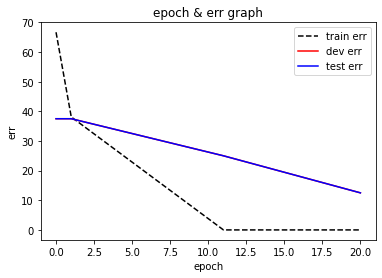

In [75]:
if (to_train):
    plt.plot(x_epoch, y_train_err, color = 'black', label = 'train err', linestyle = '--')
    plt.plot(x_epoch, y_dev_err, color = 'red', label = 'dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label = 'test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()

## 6. Evaluation for dev&test data

Normalized confusion matrix


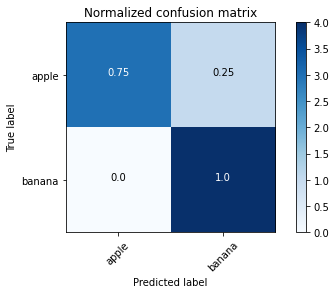

Confusion matrix, without normalization


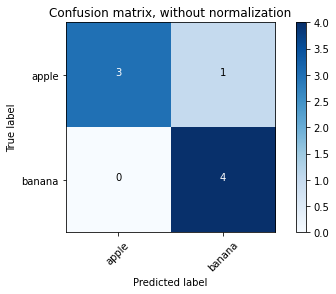

	 acc  |	 pre  |	 rec  |	 f1
 apple: 0.88 |	 1.00 |	 0.75 |	 0.86
 banana: 0.88 |	 0.80 |	 1.00 |	 0.89
*accuracy: 0.88, precision: 0.90, recall: 0.88, *f1 score: 0.87
[AP]
apple: 0.92
banana: 0.89

[mAP] 0.902
[miAP] 0.938


(array([0, 1, 1, 0, 1, 1, 0, 1]),
 array([0, 0, 1, 0, 1, 1, 0, 1]),
 array([0.93340504, 0.74420148, 0.62782574, 0.80076963, 0.73563027,
        0.90482014, 0.98827529, 0.94774604]))

In [76]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


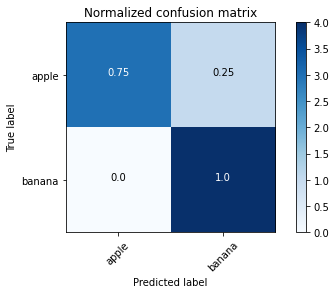

Confusion matrix, without normalization


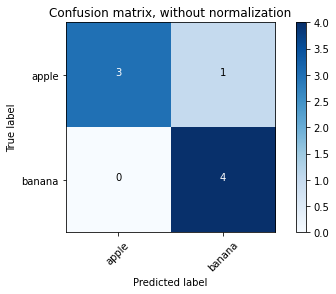

	 acc  |	 pre  |	 rec  |	 f1
 apple: 0.88 |	 1.00 |	 0.75 |	 0.86
 banana: 0.88 |	 0.80 |	 1.00 |	 0.89
*accuracy: 0.88, precision: 0.90, recall: 0.88, *f1 score: 0.87
[AP]
apple: 0.92
banana: 0.89

[mAP] 0.902
[miAP] 0.938


In [77]:
model.eval()
_,_,_=utils.EvaluateClassifier(test_batch,model,test_data.classes,batch_size)

Category: apple
 True predicted images/total apple category: 3 / 4
Predicted probability:
[0.9882753  0.01172472]


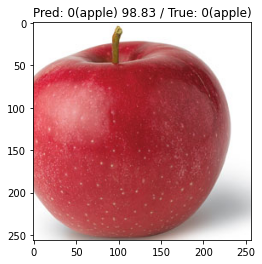

Predicted probability:
[0.93340504 0.06659498]


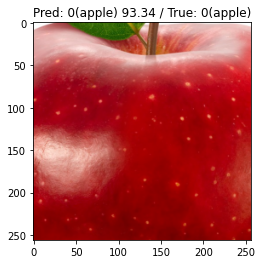

 False predicted images/total apple category: 1 / 4
Predicted probability:
[0.25579855 0.7442015 ]


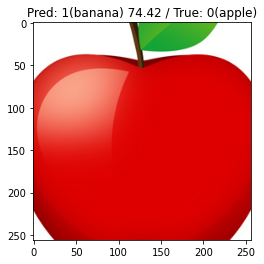

Category: banana
 True predicted images/total banana category: 4 / 4
Predicted probability:
[0.09517983 0.90482014]


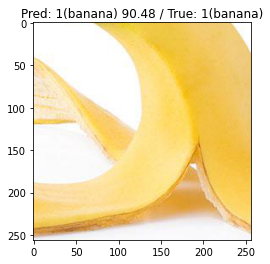

Predicted probability:
[0.37217426 0.62782574]


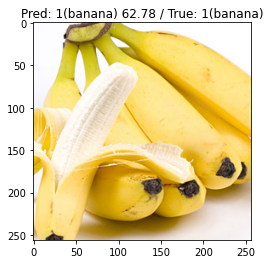

 False predicted images/total banana category: 0 / 4


In [78]:
utils.VisTFPred(dev_batch, model,test_data.classes, batch_size, i_n=2)
